This tutorial illustrates the use of LIMIX to anlayse expression datasets. For this illustration, we consider gene expression levels from a yeast genetics study with freely available data <cite data-cite="smith2008gene">(Smith & Kruglyak, 2008)</cite>.
These data span 109 individuals with 2,956 marker SNPs and expression levels for 5,493 in glucose and ethanol growth media respectively.

We start out by discussing how to do QTL mapping, implement models that consider multi loci and introduce the application of variance component models for single quantitative traits. 
Subsequently, these analysis are extended to the corresponding multi-trait models, combining the corresponding quantitative traits across both enviornment or multiple genes in a pathway.
Finally, we show how LIMIX can be used to fit variance component models that account for gene expression heteorgeneity by fitting a suitale covariance matrix.

# Setting up

In [11]:
# activiate inline plotting
%matplotlib inline

In [12]:
from setup import *

In [13]:
#import data
#the data used in this study have been pre-converted into an hdf5 file. 
#to preprocess your own data, please use limix command line brinary
file_name = tutorial_data.get_file('smith08')
geno_reader  = gr.genotype_reader_tables(file_name)
pheno_reader = phr.pheno_reader_tables(file_name)

#the data object allows to query specific genotype or phenotype data
dataset = data.QTLData(geno_reader=geno_reader,pheno_reader=pheno_reader)
#getting genotypes
snps = dataset.getGenotypes() #SNPs
position = dataset.getPos()
position,chromBounds = data_util.estCumPos(position=position,offset=100000)

# non-normalized and normalized sample relatedeness matrix
sample_relatedness_unnormalized = dataset.getCovariance(normalize=False)
sample_relatedness  = sample_relatedness_unnormalized/ \
    sample_relatedness_unnormalized.diagonal().mean()

In [14]:
#genes from lysine biosynthesis pathway
lysine_group = ['YIL094C', 'YDL182W', 'YDL131W', 'YER052C', 'YBR115C', 'YDR158W',
                'YNR050C', 'YJR139C', 'YIR034C', 'YGL202W', 'YDR234W']

[]

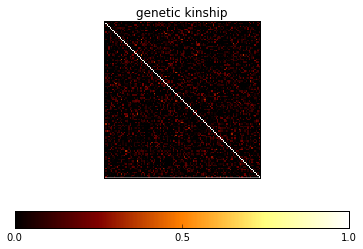

In [15]:
# plot (genetic) sample relatedeness matrix
plt = pl.subplot(1,1,1)
pl.title('genetic kinship')
pl.imshow(sample_relatedness,vmin=0,vmax=1,interpolation='none',cmap=cm.afmhot)
pl.colorbar(ticks=[0,0.5,1],orientation='horizontal')
plt.set_xticks([])
plt.set_yticks([])

# Single Trait Analysis

## Marginal single Locus Analysis

### The Genetic Model

Indicating with $N$ the number of samples,
the standard LMM considered by LIMIX is
\begin{equation}
\mathbf{y} = \mathbf{F}\boldsymbol{\alpha} + \mathbf{x}\beta + \mathbf{g}+\boldsymbol{\psi},\;\;\;
\mathbf{g}\sim\mathcal{N}\left(\mathbf{0},\sigma_g^2\mathbf{R}\right),\;
\boldsymbol{\psi}\sim\mathcal{N}\left(\mathbf{0},\sigma_e^2\mathbf{I}_N\right)
\end{equation}
where
\begin{eqnarray}
\mathbf{y}   &=& \text{phenotype vector} \in \mathcal{R}^{N,1} \\
\mathbf{F}   &=& \text{matrix of $K$ covariates} \in \mathcal{R}^{N,K} \\
\boldsymbol{\alpha} &=& \text{effect of covariates} \in \mathcal{R}^{K,1} \\
\mathbf{x}   &=& \text{genetic profile of the SNP being tested} \in \mathcal{R}^{N,1} \\
\boldsymbol{\beta}   &=& \text{effect size of the SNP} \in \mathcal{R} \\
\mathbf{R}   &=& \text{sample relatedeness matrix} \in \mathcal{R}^{N,N} \\
\end{eqnarray}
Association between phenotypic changes and the genetic markers is tested by testing $\beta\neq0$.

The model can be rewritten using the delta-representation
\begin{equation}
\mathbf{y}\sim
\mathcal{N}\left(\mathbf{W}\boldsymbol{\alpha}+\mathbf{x}\beta,
\sigma_g^2\left(\mathbf{R}+\delta\mathbf{I}\right)\right)
\end{equation}
where $\delta={\sigma_e^2}/{\sigma_g^2}$ is the signal-to-noise ratio, which can be efficiently fit for every genome wide test (parameter searchDelta). For efficient inference, LIMIX uses the identical speedups implemented in <cite data-cite="lippert2011fast">(Lippert et al., 2011)</cite> and GEMMA <cite data-cite="zhou2012genome">(Stephens et al., 2012)</cite>.

### Example: Single-trait eQTL mapping for gene YBR115C in the glucose condition

In [16]:
#create a complex query on the gene_ID and environment:
# select environment 0 (glucose) for gene YBR115C
phenotype_query = "(gene_ID=='YBR115C') & (environment==0)"

# getting the appropriate data subset
data_subsample = dataset.subsample_phenotypes(phenotype_query=phenotype_query,
                                           intersection=True)

#get variables we need from data
snps = data_subsample.getGenotypes(impute_missing=True)
phenotypes,sample_idx = data_subsample.getPhenotypes(phenotype_query=phenotype_query,
                                                     intersection=True); 
assert sample_idx.all()

#set parameters for the analysis
N, P = phenotypes.shape 
S    = snps.shape[1]

print "loaded %d samples, %d phenotypes, %s snps" % (N,P,S)

covs = None                 #covariates
searchDelta = False         #specify if delta should be optimized for each SNP
test="lrt"                  #specify type of statistical test

# Running the analysis
# when cov are not set (None), LIMIX considers an intercept (covs=SP.ones((N,1)))
lmm = qtl.test_lmm(snps=snps,pheno=phenotypes.values,
                   K=sample_relatedness,covs=covs, test=test)

pvalues = lmm.getPv()       # 1xS vector of p-values (S=X.shape[1])
#convert P-values to a DataFrame for nice output writing:
pvalues = pd.DataFrame(data=pvalues.T,index=data_subsample.geno_ID,
                       columns=phenotypes.columns)

betas = lmm.getBetaSNP()    # 1xS vector of effect sizes (S=X.shape[1])
#convert betas to a DataFrame for nice output writing:
betas = pd.DataFrame(data=betas.T,index=data_subsample.geno_ID,
                     columns=phenotypes.columns)

loaded 109 samples, 1 phenotypes, 2956 snps


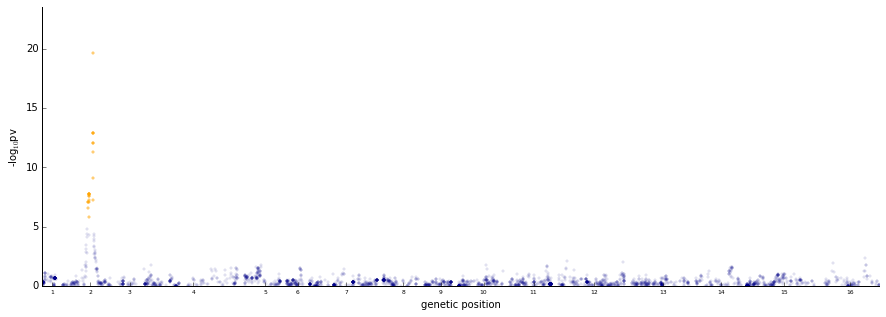

In [17]:
pl.figure(figsize=[15,5])
plot_manhattan(position['pos_cum'],pvalues['YBR115C:0'],chromBounds)

### Example: Single-trait eQTL mapping for all genes in the pathways in the glucos condition

In [18]:
#create a complex query on the gene_ID and environment:
# select environment 0 for all genes in lysine_group
phenotype_query = "(gene_ID in %s) & (environment==0)" % str(lysine_group)

data_subsample = dataset.subsample_phenotypes(phenotype_query=phenotype_query,
                                           intersection=True)

#get variables we need from data
snps = data_subsample.getGenotypes(impute_missing=True)
phenotypes,sample_idx = data_subsample.getPhenotypes(phenotype_query=phenotype_query,
                                                     intersection=True)
assert sample_idx.all()

sample_relatedness = data_subsample.getCovariance()

#set parameters for the analysis
N, P = phenotypes.shape
S    = snps.shape[1]

print "loaded %d samples, %d phenotypes, %s snps" % (N,P,S)

covs = None                 #covariates
searchDelta = False         #specify if delta is optimized for each SNP
test="lrt"                  #specify type of statistical test

# Running the analysis
# when cov are not set (None), LIMIX considers an intercept 
# (covs=SP.ones((N,1))) note, as phenotypes is a matrix, 
# LIMIX automatically carries out an association scan for each phenotype
lmm = qtl.test_lmm(snps=snps,pheno=phenotypes.values,
                   K=sample_relatedness,covs=covs,test=test)

# get p-values
pvalues = lmm.getPv()       # 1xS vector of p-values (S=X.shape[1])
#convert P-values to a DataFrame for nice output writing:
pvalues = pd.DataFrame(data=pvalues.T,index=data_subsample.geno_ID,
                       columns=phenotypes.columns)
betas = lmm.getBetaSNP()    # 1xS vector of effect sizes (S=X.shape[1])
#convert betas to a DataFrame for nice output writing:
betas = pd.DataFrame(data=betas.T,index=data_subsample.geno_ID,
                     columns=phenotypes.columns)

loaded 109 samples, 11 phenotypes, 2956 snps


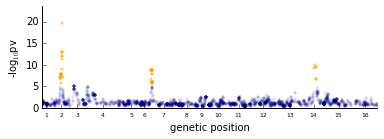

In [10]:
# plotting minimum pv across genes
pv_min = lmm.getPv().min(0)
plt = pl.subplot(2,1,1)
plot_manhattan(position['pos_cum'],pv_min,chromBounds)

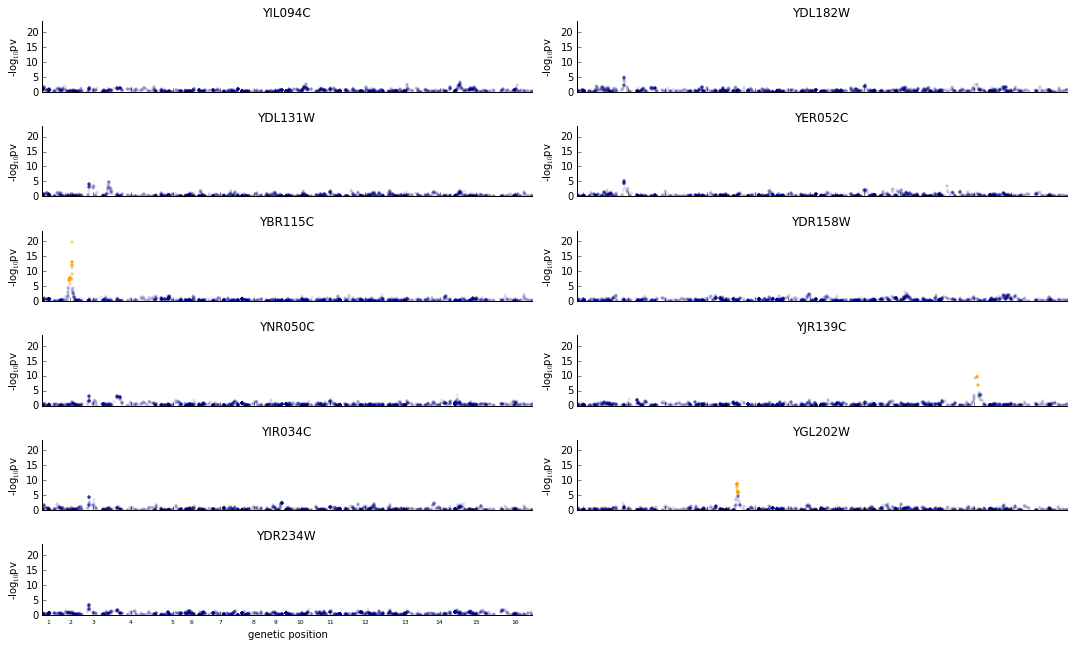

In [19]:
# plotting all manhattan plots
pl.figure(1,figsize=(15,16))
lim = -1.2*sp.log10(lmm.getPv().min())
for g in range(P):
    plt = pl.subplot(P,2,g+1)
    pl.title(lysine_group[g])
    if g!=P-1:   xticklabels = False
    else:        xticklabels = True
    plot_manhattan(position['pos_cum'],pvalues[lysine_group[g]+":0"],
                   chromBounds,lim=lim,xticklabels=xticklabels)
pl.tight_layout()

## Multi locus Single Trait Model

### The Genetic Model

In addition to a single-locus marginal analysis, LIMIX can be used to performa multi-locus scan by step-wise regression. 
In the univariate (single-trait) case, this approach is analogus to the proecudere described in <cite data-cite="segura2012efficient">(Segura et al., 2012)</cite>.
Briefly, the standard univariate scan is extended by iterative inclusion of the most associated SNP as a covariate. The proceudere is terminated after a predefined p-value or q-value treshold or the maximum number of iterations is reached.

Note, care needs to be taken when interpreting these signifance levels as they are compromised by an intrinsic multiple testing bias. It is adviced to interpret the model output carefully, consdering both signifiance levels and other metrics, such as BIC <cite data-cite="segura2012efficient">(see discussion in Segura et al., 2012)</cite>.


### Example: Single-trait eQTL mapping for gene YBR115C the glucose condition

In [20]:
#getting data
#create a complex query on the gene_ID and environment:
#select environment 0 for gene YBR115C
phenotype_query = "(gene_ID=='YBR115C') & (environment==0)"

data_subsample = dataset.subsample_phenotypes(phenotype_query=phenotype_query,
                                           intersection=True)

#get variables we need from data
snps = data_subsample.getGenotypes(impute_missing=True)
phenotypes,sample_idx = data_subsample.getPhenotypes(phenotype_query=phenotype_query,
                                                     intersection=True)
assert sample_idx.all()

sample_relatedness = data_subsample.getCovariance()

#set parameters for the analysis
N, P = phenotypes.shape   
S    = snps.shape[1]

print "loaded %d samples, %d phenotypes, %s snps" % (N,P,S)

covs = None                 #covariates
searchDelta = False         #specify if delta should be optimized for each SNP
test="lrt"                  #specify type of statistical test

# Running the analysis
threshold = 0.01/snps.shape[1] 
# inclusion threshold on pvalues 
#(Bonferroni corrected significance level of 1%)
maxiter = 10                # maximum number of iterations
lmm, RV = qtl.forward_lmm(snps,phenotypes.values,K=sample_relatedness,
                          qvalues=False,threshold=threshold,maxiter=maxiter)
# RV contains:
# - iadded:   array of indices of SNPs included in order of inclusion
# - pvadded:  array of Pvalues obtained by the included SNPs before inclusion
# - pvall:   [maxiter x S] SP.array of Pvalues for all iterations

loaded 109 samples, 1 phenotypes, 2956 snps


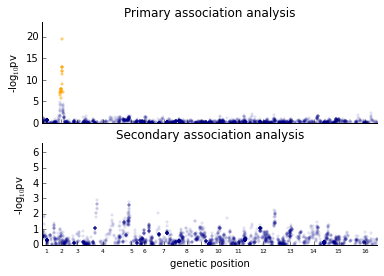

In [21]:
# plot primay p-values and conditional association results
pvall = RV['pvall']
plt = pl.subplot(2,1,1)
pl.title('Primary association analysis')
plot_manhattan(position['pos_cum'],pvall[0],chromBounds,xticklabels = False)
plt = pl.subplot(2,1,2)
pl.title('Secondary association analysis')
plot_manhattan(position['pos_cum'],pvall[1],chromBounds,xticklabels = True)

## Variance Component Models

In addition to association testing using fixed effects, LIMIX enables flexible fitting of variance component models. Here, we illustrate the usage of variance component models fit to single genes.

### The Genetic Model

The model considered by the LIMIX variance decomposition module is an extension of the genetic model
employed in standard GWAS, however considers multiple random effects terms:
\begin{equation}
\mathbf{y} = \mathbf{F}\boldsymbol{\alpha} + \sum_{x}\mathbf{u}^{(x)} + \boldsymbol{\psi},\;\;\;\;
\mathbf{u}^{(x)}\sim\mathcal{N}\left(\mathbf{0},{\sigma^{(x)}}^2\mathbf{R}^{(x)}\right),\;
\boldsymbol{\Psi}\sim\mathcal{N}\left(\mathbf{0},\sigma_e^2\mathbf{I}_N\right)
\end{equation}
where
\begin{eqnarray}
\mathbf{y}   &=& \text{phenotype vector} \in \mathcal{R}^{N,1} \\
\mathbf{F}   &=& \text{matrix of $K$ covariates} \in \mathcal{R}^{N,K} \\
\boldsymbol{\alpha} &=& \text{effect of covariates} \in \mathcal{R}^{K,1} \\
\mathbf{R}^{(x)}   &=& \text{is the sample covariance matrix for contribution $x$} \in \mathcal{R}^{N,N} \\
\end{eqnarray}

If $\mathbf{R}$ is a genetic contribution from set of SNPs $\mathcal{S}$,
with a bit of abuse of notation we can write
$\mathbf{R}= \frac{1}{C}\mathbf{X}_{:,\,\mathcal{S}}{\mathbf{X}_{:,\,\mathcal{S}}}^T$
where $C=\frac{1}{N}\text{trace}\left(\mathbf{X}_{:,\,\mathcal{S}_i}{\mathbf{X}_{:,\,\mathcal{S}_i}}^T\right)$.

LIMIX supports an arbitrary number of fixed or random effects to be included in the model.


### Example: cis/trans Variance Decomposition in the glucose condition

Here we use the LIMIX variance decomposition module to quantify the variability
in gene expression explained by proximal (cis) and distal (trans) genetic variation.
To do so, we build a linear mixed model with a fixed effect intercept,
two random effects for cis and trans genetic effects and a noise random effect:

\begin{equation}
\mathbf{y} = \mathbf{1}_N\mu + \mathbf{u}^{(cis)} + \mathbf{u}^{(trans)} + \boldsymbol{\psi},\;\;\;\;
\mathbf{u}^{(cis)}\sim\mathcal{N}\left(\mathbf{0},{\sigma^{(x)}}^2\mathbf{R}^{(cis)}\right), \\
\mathbf{u}^{(trans)}\sim\mathcal{N}\left(\mathbf{0},{\sigma^{(x)}}^2\mathbf{R}^{(trans)}\right),
\boldsymbol{\Psi}\sim\mathcal{N}\left(\mathbf{0},\sigma_e^2\mathbf{I}_N\right)
\end{equation}

where $\mathbf{R}^\text{(cis)}$ and $\mathbf{R}^\text{(trans)}$ are the local and distal relatedeness matrices,
built considering all SNPs in cis and trans (i.e., not in cis) respectively.
As cis region is defined by the 50kb region around each gene.

The gene-model is fitted to gene expression in environment 0 for
all genes in the Lysine Biosynthesis pathway and variance components are averaged thereafter to obtain pathway
based variance components.

In [22]:
# loop over genes and fit variance component model
gene_var = []
genes_analyzed = []
K_all = dataset.getCovariance(normalize=False)
    
for gene_idx,gene in enumerate(lysine_group):
    #create a complex query on the gene_ID and environment:
    # select environment 0 for all genes in lysine_group
    phenotype_query = "(gene_ID=='%s') & (environment==0)" % gene
    print "running variance decomposition on %s" % phenotype_query
    data_subsample = dataset.subsample_phenotypes(phenotype_query=phenotype_query,
                                               intersection=True)
    
    #get variables we need from data
    phenotypes,sample_idx = data_subsample.getPhenotypes(phenotype_query=phenotype_query,
                                                         intersection=True) 
    assert sample_idx.all()
    if phenotypes.shape[1]==0:
        continue
    #snps = data_subsample.getGenotypes(impute_missing=True)
    pos_gene = data_subsample.pheno_reader.get_pos(phenotype_query=phenotype_query)
    K_cis = data_subsample.getCovariance(normalize=False,pos_start=pos_gene["start"][0],
                                         pos_end=pos_gene["end"][0],windowsize=5e5)
    K_trans = K_all-K_cis
    K_cis /= K_cis.diagonal().mean()
    K_trans /= K_trans.diagonal().mean()
    
    # variance component model
    vc = var.VarianceDecomposition(phenotypes.values)
    vc.addFixedEffect()
    vc.addRandomEffect(K=K_cis)
    vc.addRandomEffect(K=K_trans)
    vc.addRandomEffect(is_noise=True)
    vc.optimize()
    
    # get variances
    # vc.getVariances() returs a vector of variances explained
    # by the three random effects in order of addition (cis,trans,noise)
    _var = vc.getVarianceComps()
    
    gene_var.append(_var)
    genes_analyzed.append(gene)
# concatenate in a unique matrix
gene_var = sp.concatenate(gene_var)

running variance decomposition on (gene_ID=='YIL094C') & (environment==0)
running variance decomposition on (gene_ID=='YDL182W') & (environment==0)
running variance decomposition on (gene_ID=='YDL131W') & (environment==0)
running variance decomposition on (gene_ID=='YER052C') & (environment==0)
running variance decomposition on (gene_ID=='YBR115C') & (environment==0)
running variance decomposition on (gene_ID=='YDR158W') & (environment==0)
running variance decomposition on (gene_ID=='YNR050C') & (environment==0)
running variance decomposition on (gene_ID=='YJR139C') & (environment==0)
running variance decomposition on (gene_ID=='YIR034C') & (environment==0)
running variance decomposition on (gene_ID=='YGL202W') & (environment==0)
running variance decomposition on (gene_ID=='YDR234W') & (environment==0)


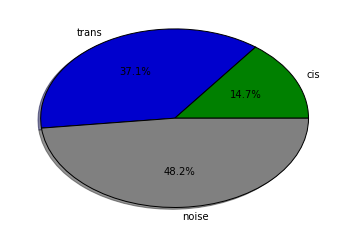

In [23]:
#normalize variance component and average
gene_var/=gene_var.sum(1)[:,sp.newaxis]
var_mean = gene_var.mean(0)
column_labels = ["cis","trans","noise"]
colors = ['Green','MediumBlue','Gray']
p=pl.pie(var_mean,labels=column_labels,autopct='%1.1f%%',colors=colors,
       shadow=True, startangle=0)
#convert var to a DataFrame for nice output writing:
gene_var = pd.DataFrame(data=gene_var,index=genes_analyzed,columns=column_labels)

#convert betas to a DataFrame for nice output writing:
var_mean = pd.DataFrame(data=var_mean[sp.newaxis,:],index=["lysine_biosynthesis"],
                        columns=column_labels)

# Multi Trait Analysis

Denoting with $N$ and $P$ the number of samples and phenotypes in the analysis,
LIMIX models the $N \times P$ matrix-variate phenotype $\mathbf{Y}$
as a sum of fixed and random effects in a multivariate mixed model framework.

Single-trait models only consider the across-sample axis of variation and thus
- fixed effects need only specification of a sample design (denoted by $\mathbf{F}$ so far)
- random effects need only specification of a sample covariance matrix (denoted by $\mathbf{R}$ so far),
which describes the correlation across samples induced by the random effect

Conversely, multi-trait models also consider the across-trait axis of variation and thus
- fixed effects also require a trait design (denoted with $\mathbf{A}$ in the following)
- random effects also require a trait covariance matrix (denoted with $\mathbf{C}$ in the following),
which describes the correlation across traits induced by the random effect

Different forms of trait designs for fixed effects and trait covariances for random effects
reflect different hypothesis on how these contributions affect phenotypes
(e.g., shared and trait-specific effects).
In the following, we will show how LIMIX can be used for different analysis of multiple traits
wisely choosing trait designs and covariances.

We decided to start with multi-trait variance components models before going to
multi-trait GWAS analysis, including single-locus and multi-locus analysis.
In the next section we will be discussing more subtle problems as regularization and model selection. 

## Variance decomposition

### Genetic Model

The general multi-trait linear mixed models considered in the LIMIX variance decomposition module can be written as
\begin{equation}
\mathbf{Y} = \sum_i\mathbf{F}_i\mathbf{W}_i\mathbf{A}^\text{(cov)}_i + \sum_{x}\mathbf{U}^{(x)} + \boldsymbol{\Psi},\;\;\;\;
\mathbf{U}^{(x)}\sim\text{MVN}\left(\mathbf{0},\mathbf{R}^{(x)},\mathbf{C}^{(x)}\right),\;
\boldsymbol{\Psi}\sim\text{MVN}\left(\mathbf{0},\mathbf{I}_N,\mathbf{C}^\text{(noise)}\right)
\end{equation}
where
\begin{eqnarray}
\mathbf{Y}   &=& \text{phenotype vector} \in \mathcal{R}^{N,P} \\
\mathbf{F}_i   &=& \text{sample designs for fixed effects} \in \mathcal{R}^{N,K} \\
\mathbf{W}_i   &=& \text{effect size matrix of covariates} \in \mathcal{R}^{K,L} \\
\mathbf{A}^\text{(cov)} &=& \text{trait design for the fixed effect} \in \mathcal{R}^{L,P} \\
\mathbf{R}^{(x)}   &=& \text{sample covariance matrix for contribution $x$} \in \mathcal{R}^{N,N} \\
\mathbf{C}^{(x)}   &=& \text{trait covariance matrix for contribution $x$} \in \mathcal{R}^{P,P} \\
\mathbf{C}^\text{(noise)}   &=& \text{residual trait covariance matrix} \in \mathcal{R}^{P,P} \\
\end{eqnarray}


The variance decomposition module in LIMIX allows the user to build the model by adding any number of fixed and random effects, specify different designs for fixed effects and choose covariance models for random effects. In case of only two random effects LIMIX uses speedups beaking the $O(N^3P^3)$ complexity in $O(N^3+P^3)$.

In the following we show two different example.
In the first example we construct interpretable trait covariances for random effects and build
a model that dissects gene expression variability across environmental and cis and trans genetic effects,
and their interactions (cis GxE, trans GxE).
In the second example we show how to use the fast implementation for a two-random-effect model,
one for genetic effects and the other for residuals.
Such a model is the natural extention to multi-trait analysis of the null model in single-trait GWAS
and it is the first step of any multi-trait GWAS analysis performed in LIMIX.



### Example 1: GxE variance decomposition for Lysine Biosynthesis

Indicating with $N$ and $E=2$ respectively the number of samples and the number of environments,
we considered for each gene a model consisting of
an envoronment-specific intercept term,
a random effect for cis genetic effects,
a random effect for trans genetic effects,
and a noise random effect term.

The model can be written
\begin{equation}
\mathbf{Y}=\mathbf{FWA}+\mathbf{U}^\text{(cis)}+\mathbf{U}^\text{(trans)}\boldsymbol{\Psi}
\end{equation}
\begin{equation}
\mathbf{U}^\text{(cis)}\sim\text{MVN}(\mathbf{0},\mathbf{R}^\text{(cis)},\mathbf{C}^\text{(cis)}),
\mathbf{U}^\text{(trans)}\sim\text{MVN}(\mathbf{0},\mathbf{R}^\text{(trans)},\mathbf{C}^\text{(trans)}),\;
\boldsymbol{\Psi}\sim\text{MVN}(\mathbf{0},\mathbf{I}_N,\mathbf{C}_n)
\nonumber
\end{equation}
where $\mathbf{R}^\text{(cis)}$ and $\mathbf{R}^\text{(trans)}$ are the local and distal kinships,
built considering all SNPs in cis and trans (i.e., not in cis) respectively.
As in the single-trait analysis, we considered as cis region
the region of 500kb downstream and upstream the gene.

To dissect persistent and specific variance compoents we considered a 'block+diagonal' form for $C^{(x)}$:
\begin{equation}
C^{(x)} =
{a^{(x)}}^2
\left[
\begin{array}{cc}
1 & 1\\
1 & 1
\end{array}
\right]
+
\left[
\begin{array}{cc}
{c^{(x)}_1}^2 & 0\\
0 & {c^{(x)}_2}^2
\end{array}
\right]
=
\left[
\begin{array}{cc}
{a^{(x)}}^2+{c^{(x)}_1}^2 & {a^{(x)}}^2\\
{a^{(x)}}^2 & {a^{(x)}}^2+{c^{(x)}_2}^2
\end{array}
\right]
\end{equation}
Variance of persistent and specific (GxE) effects from term $x$ are ${a^{(x)}}^2$ and $\frac{1}{2}\left({c_1^{(x)}}^2+{c_2^{(x)}}^2\right)$ while the variance explained by pure environmental shift can be calculated as $\text{var}\left(\text{vec}(\mathbf{FWA})\right)$.

In [24]:
# loop over genes and fit variance component model
var_gene = []
genes_analyzed = []
K_all = dataset.getCovariance(normalize=False)
    
for gene_idx,gene in enumerate(lysine_group):
    #create a complex query on the gene_ID and environment:
    # select (all environments for) the current gene in lysine_group
    phenotype_query = "(gene_ID=='%s')" % gene
    print "running variance decomposition on %s" % phenotype_query
    data_subsample = dataset.subsample_phenotypes(phenotype_query=phenotype_query,
                                               intersection=True)
    
    #get variables we need from data
    phenotypes,sample_idx = data_subsample.getPhenotypes(phenotype_query=phenotype_query,
                                                         intersection=True,center=False) 
    assert sample_idx.all()
    phenotypes-=phenotypes.values.mean()
    phenotypes/=phenotypes.values.std()
    if phenotypes.shape[1]==0:#gene not found
        continue
    #snps = data_subsample.getGenotypes(impute_missing=True)
    pos_gene = data_subsample.pheno_reader.get_pos(phenotype_query=phenotype_query)
    K_cis = data_subsample.getCovariance(normalize=False,pos_start=pos_gene["start"][0],
                                         pos_end=pos_gene["end"][0],windowsize=5e5)
    K_trans = K_all-K_cis
    K_cis /= K_cis.diagonal().mean()
    K_trans /= K_trans.diagonal().mean()

    # variance component model
    vc = var.VarianceDecomposition(phenotypes.values)
    vc.addFixedEffect()
    vc.addRandomEffect(K=K_cis,trait_covar_type='block_diag')
    vc.addRandomEffect(K=K_trans,trait_covar_type='block_diag')
    vc.addRandomEffect(is_noise=True,trait_covar_type='block_diag')
    vc.optimize()
    
    # environmental variance component
    vEnv = vc.getWeights().var()
    # cis and cisGxE variance components
    Ccis  = vc.getTraitCovar(0)
    a2cis = Ccis[0,1]
    c2cis = Ccis.diagonal().mean()-a2cis
    # trans and cisGxE variance components
    Ctrans  = vc.getTraitCovar(1)
    a2trans = Ctrans[0,1]
    c2trans = Ctrans.diagonal().mean()-a2trans
    # noise variance components
    Cnois = vc.getTraitCovar(2)
    vNois = Cnois.diagonal().mean()
    
    # Append
    var_gene.append(sp.array([[vEnv,a2cis,c2cis,a2trans,c2trans,vNois]]))
    genes_analyzed.append(gene)
# concatenate in a unique matrix
var_gene = sp.concatenate(var_gene)

running variance decomposition on (gene_ID=='YIL094C')
running variance decomposition on (gene_ID=='YDL182W')
running variance decomposition on (gene_ID=='YDL131W')
running variance decomposition on (gene_ID=='YER052C')
running variance decomposition on (gene_ID=='YBR115C')
running variance decomposition on (gene_ID=='YDR158W')
running variance decomposition on (gene_ID=='YNR050C')
running variance decomposition on (gene_ID=='YJR139C')
running variance decomposition on (gene_ID=='YIR034C')
running variance decomposition on (gene_ID=='YGL202W')
running variance decomposition on (gene_ID=='YDR234W')


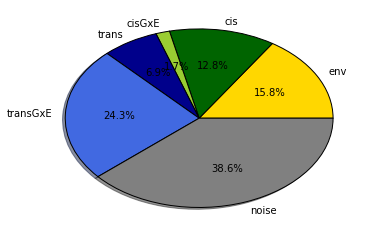

In [25]:
#normalize variance component and average
var_gene/=var_gene.sum(1)[:,sp.newaxis]
var_mean = var_gene.mean(0)
labels = ['env','cis','cisGxE','trans','transGxE','noise']
colors = ['Gold','DarkGreen','YellowGreen','DarkBlue','RoyalBlue','Gray']
p=pl.pie(var_mean,labels=labels,autopct='%1.1f%%',colors=colors,shadow=True, startangle=0)

### Example 2: fast variance decomposition

In this example we consider a model with only two random effects: one genetic and a noise term
and show how to perform fast inference to learn the trait covariance matrices. The mathematical tricks used in LIMIX have also been proposed in <cite data-cite="rakitschall">Rakitsch et al., 2013</cite> and <cite data-cite="zhou2013efficient">Zhou et al., 2013</cite>.
We apply the model to the expression in the glucose condition and for 11 genes of the lysine biosynthesis pathway.



In [26]:
#create a complex query on the gene_ID and environment:
# select environment 0 for all genes in lysine_group
phenotype_query = "(gene_ID in %s) & (environment==0)" % str(lysine_group)

data_subsample = dataset.subsample_phenotypes(phenotype_query=phenotype_query,
                                           intersection=True)

#get variables we need from data
phenotypes,sample_idx = data_subsample.getPhenotypes(phenotype_query=phenotype_query,
                                                     intersection=True) 
assert sample_idx.all()

sample_relatedness = data_subsample.getCovariance()

#set parameters for the analysis
N, G = phenotypes.shape          

# variance component model
vc = var.VarianceDecomposition(phenotypes.values)
vc.addFixedEffect()
vc.addRandomEffect(K=sample_relatedness,trait_covar_type='lowrank_diag',rank=4)
vc.addRandomEffect(is_noise=True,trait_covar_type='lowrank_diag',rank=4)
vc.optimize()
# retrieve geno and noise covariance matrix
Cg = vc.getTraitCovar(0)
Cn = vc.getTraitCovar(1)

[]

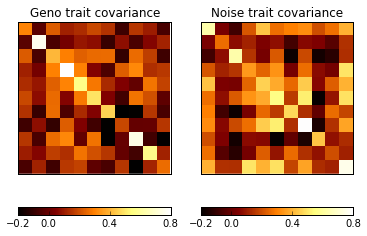

In [27]:
# plot trait covariance matrices
plt = pl.subplot(1,2,1)
pl.title('Geno trait covariance')
pl.imshow(Cg,vmin=-0.2,vmax=0.8,interpolation='none',cmap=cm.afmhot)
pl.colorbar(ticks=[-0.2,0.,0.4,0.8],orientation='horizontal')
plt.set_xticks([])
plt.set_yticks([])
plt = pl.subplot(1,2,2)
pl.title('Noise trait covariance')
pl.imshow(Cn,vmin=-0.2,vmax=0.8,interpolation='none',cmap=cm.afmhot)
pl.colorbar(ticks=[-0.2,0.,0.4,0.8],orientation='horizontal')
plt.set_xticks([])
plt.set_yticks([])

## Multi Trait GWAS

The genetic model considered by LIMIX for multivariate GWAS consists of
fixed effects for covariates,
a fixed effect for the SNP being tested,
a random effect for the polygenic effect
and a noisy random effect term.

The model can be written
\begin{equation}
\mathbf{Y}=
\sum_i\mathbf{F}_i\mathbf{W}_i\mathbf{A}^\text{(cov)}_i
+\mathbf{XBA}_1^\text{(snp)}+\mathbf{G}+\boldsymbol{\Psi},\;\;\;\;\;
\mathbf{G}\sim\text{MVN}(\mathbf{0},\mathbf{K},\mathbf{C}_g),\;
\boldsymbol{\Psi}\sim\text{MVN}(\mathbf{0},\mathbf{I}_N,\mathbf{C}_n),
\end{equation}
where
\begin{eqnarray}
\mathbf{Y}   &=& \text{matrix-variate phenotype} \in \mathcal{R}^{N,P} \\
\mathbf{F_i}   &=& \text{sample design for covariates} \in \mathcal{R}^{N,K} \\
\mathbf{W_i}   &=& \text{effect size matrix of covariates} \in \mathcal{R}^{K,L} \\
\mathbf{A_i}^\text{(cov)} &=& \text{trait design for the fixed effect} \in \mathcal{R}^{L,P} \\
\mathbf{X}   &=& \text{genetic profile of the SNP} \in \mathcal{R}^{N,1} \\
\mathbf{B}   &=& \text{effect sizes of the SNP} \in \mathcal{R}^{1,M} \\
\mathbf{A}_1^\text{(snp)} &=& \text{trait design for the fixed effect} \in \mathcal{R}^{M,P} \\
\mathbf{K}   &=& \text{sample relatedeness matrix} \in \mathcal{R}^{N,N} \\
\mathbf{C}_g &=& \text{genetic trait covariance matrix} \in \mathcal{R}^{P,P} \\
\mathbf{I}_N &=& \text{sample noise matrix} \in \mathcal{R}^{N,N} \\
\mathbf{C}_n &=& \text{noise trait covariance matrix} \in \mathcal{R}^{P,P}
\end{eqnarray}

Prior to any multi-trait GWAS analysis,
LIMIX learns the trait covariates matrices on the mixed model without the fixed effect from the SNP.
However, LIMIX allows the user to set refitting of the signal-to-noise ratio $\delta$ SNP-by-SNP during the GWAS
as in single-trait analysis.

In general, LIMIX tests for particular trait designs of the fixed effect
$\mathbf{A}_1^\text{(snp)}\neq\mathbf{A}_0^\text{(snp)}$.
As shown extensively below, specifying opportunately $\mathbf{A}_1^\text{(snp)}$ and $\mathbf{A}_0^\text{(snp)}$
different biological hypothesis can be tested.

An alternative efficient implement of multi trait GWAS is available in GEMMA <cite data-cite="zhou2013efficient">(Zhou et al., 2013)</cite>, however LIMIX permits more flexible models to be constructed and enables automated regularization of trait covariances (see below).


### Any effect test

Association between any of the phenotypes and the genetic marker can be tested by setting
\begin{equation}
\mathbf{A}_1^\text{(snp)} = \mathbf{I}_P,\;\;\;
\mathbf{A}_0^\text{(snp)} = \mathbf{0}
\end{equation}
This is a $P$ degrees of freedom test.

In this context, multi-trait modelling is considered just to empower detection
of genetic loci while there is no interest in the specific design of the association.

#### Example: any effect test for gene YJR139C across environments

Here we test for genetic effects on expression of one gene
either in environment 0 or in environment 1.


In [28]:
# Get data
# select all environmens for gene YJR139C in lysine_group
phenotype_query = "(gene_ID == 'YJR139C')"

data_subsample = dataset.subsample_phenotypes(phenotype_query=phenotype_query,
                                           intersection=True)

#get variables we need from data
snps = data_subsample.getGenotypes(impute_missing=True)
phenotypes,sample_idx = data_subsample.getPhenotypes(phenotype_query=phenotype_query,
                                                     intersection=True) 
assert sample_idx.all()

sample_relatedness = data_subsample.getCovariance()

#set parameters for the analysis
N, P = phenotypes.shape          

covs = None                 #covariates
Acovs = None                #the design matrix for the covariates   
Asnps = sp.eye(P)           #the design matrix for the SNPs
K1r = sample_relatedness    #the first sample-sample covariance matrix (non-noise)
K2r = sp.eye(N)             #the second sample-sample covariance matrix (noise)
K1c = None                  #the first phenotype-phenotype covariance matrix (non-noise)
K2c = None                  #the second phenotype-phenotype covariance matrix (noise)
covar_type = 'freeform'     #the type of the trait/trait covariance to be estimated 
searchDelta = False         #specify if delta should be optimized for each SNP
test="lrt"                  #specify type of statistical test

# Running the analysis
# when cov are not set (None), LIMIX considers an intercept (covs=SP.ones((N,1)))
lmm, pvalues = qtl.test_lmm_kronecker(snps,phenotypes.values,covs=covs,Acovs=Acovs,
                                      Asnps=Asnps,K1r=K1r,trait_covar_type=covar_type)

#convert P-values to a DataFrame for nice output writing:
pvalues = pd.DataFrame(data=pvalues.T,index=data_subsample.geno_ID,columns=['YJR139C'])

.. Training the backgrond covariance with a GP model
Background model trained in 0.03 s


/Users/stegle/research/users/stegle/limix/limix/modules/qtl.py:261: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if K1r==None:


REMARKS:
- kronecker_lmm always considers Asnp0=0
thus only Asnp1 needs to be specified
- if trait covariance matrices (arguments K1c and K2c are not specified)
kronecker_lmm implements the variance decomposition module to estimate them.
In this case, the user can specify the trait covariance model to considered (covar_type and rank).

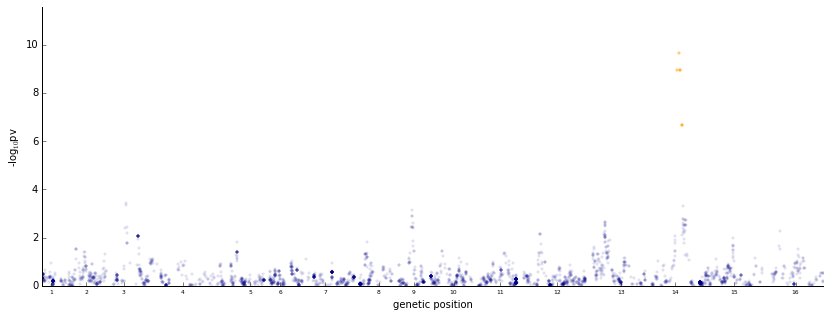

In [29]:
pl.figure(figsize=[14,5])
plot_manhattan(position['pos_cum'],pvalues['YJR139C'],chromBounds)

### Common effect test

A common effect test is a 1 degree of freedom test and can be done by setting
\begin{equation}
\mathbf{A}_1^\text{(snp)} = \mathbf{1}_{1,P},\;\;\;
\mathbf{A}_0^\text{(snp)} = \mathbf{0}
\end{equation}

#### Example: common effect test for gene YJR139C across environments

In [30]:
# Get data
# select all environmens for gene YJR139C in lysine_group
phenotype_query = "(gene_ID == 'YJR139C')"

data_subsample = dataset.subsample_phenotypes(phenotype_query=phenotype_query,
                                           intersection=True)

#get variables we need from data
snps = data_subsample.getGenotypes(impute_missing=True)
phenotypes,sample_idx = data_subsample.getPhenotypes(phenotype_query=phenotype_query,
                                                     intersection=True)
assert sample_idx.all()

sample_relatedness = data_subsample.getCovariance()

#set parameters for the analysis
N, P = phenotypes.shape          

covs = None                 #covariates
Acovs = None                #the design matrix for the covariates   
Asnps = sp.ones((1,P))      #the design matrix for the SNPs
K1r = sample_relatedness    #the first sample-sample covariance matrix (non-noise)
K2r = sp.eye(N)             #the second sample-sample covariance matrix (noise)
K1c = None                  #the first phenotype-phenotype covariance matrix (non-noise)
K2c = None                  #the second phenotype-phenotype covariance matrix (noise)
covar_type = 'freeform'     #the type of the trait/trait covariance to be estimated 
searchDelta = False         #specify if delta should be optimized for each SNP
test="lrt"                  #specify type of statistical test

# Running the analysis
# when cov are not set (None), LIMIX considers an intercept (covs=SP.ones((N,1)))
lmm, pvalues = qtl.test_lmm_kronecker(snps,phenotypes.values,covs=covs,Acovs=Acovs,
                                      Asnps=Asnps,K1r=K1r,trait_covar_type=covar_type)

#convert P-values to a DataFrame for nice output writing:
pvalues = pd.DataFrame(data=pvalues.T,index=data_subsample.geno_ID,columns=['YJR139C'])

.. Training the backgrond covariance with a GP model
Background model trained in 0.03 s


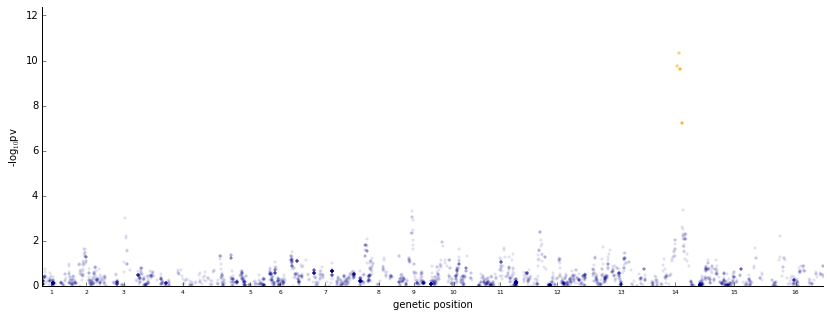

In [31]:
pl.figure(figsize=[14,5])
plot_manhattan(position['pos_cum'],pvalues['YJR139C'],chromBounds)

### Specific effect test

For a specifc effect test for trait $p$
the alternative model is set to have both a common and a specific effect
for transcript $p$ from the SNP while the null model has only a common effect.

It is a 1 degree of freedom test and,
in the particular case of $P=3$ traits and for $p=0$, it can be done by setting
\begin{equation}
\mathbf{A}_1^\text{(snp)} =
\begin{pmatrix}
  1 & 0 & 0 \\
  1 & 1 & 1
 \end{pmatrix}
\;\;\;,
\mathbf{A}_0^\text{(snp)} = \mathbf{1}_{1,3}
\end{equation}

#### Example: specific effect test for gene YJR139C across environmentsExample

In [32]:
# select all environmens for gene YJR139C in lysine_group
phenotype_query = "(gene_ID == 'YJR139C')"

data_subsample = dataset.subsample_phenotypes(phenotype_query=phenotype_query,
                                           intersection=True)

#get variables we need from data
snps = data_subsample.getGenotypes(impute_missing=True)
phenotypes,sample_idx = data_subsample.getPhenotypes(phenotype_query=phenotype_query,
                                                     intersection=True) 
assert sample_idx.all()

sample_relatedness = data_subsample.getCovariance()

#set parameters for the analysis
N, P = phenotypes.shape          

covs = None                 #covariates
Acovs = None                #the design matrix for the covariates   
Asnps0 = sp.ones((1,P))     #the null model design matrix for the SNPs
Asnps1 = sp.zeros((2,P))    #the alternative model design matrix for the SNPs
Asnps1[0,:] = 1.0           
Asnps1[1,0] = 1.0       
K1r = sample_relatedness    #the first sample-sample covariance matrix (non-noise)
K2r = sp.eye(N)             #the second sample-sample covariance matrix (noise)
K1c = None                  #the first phenotype-phenotype covariance matrix (non-noise)
K2c = None                  #the second phenotype-phenotype covariance matrix (noise)
covar_type = 'freeform'     #the type of the trait/trait covariance to be estimated 
searchDelta = False         #specify if delta should be optimized for each SNP
test="lrt"                  #specify type of statistical test

# Running the analysis
# when cov are not set (None), LIMIX considers an intercept (covs=SP.ones((N,1)))
pvalues = qtl.test_interaction_lmm_kronecker(snps=snps,phenos=phenotypes.values,
    covs=covs,Acovs=Acovs,Asnps1=Asnps1,Asnps0=Asnps0,K1r=K1r,K2r=K2r,K1c=K1c,K2c=K2c,
    trait_covar_type=covar_type,searchDelta=searchDelta)


#convert P-values to a DataFrame for nice output writing:
pvalues = pd.DataFrame(data=sp.concatenate(pvalues).T,index=data_subsample.geno_ID,
                       columns=["specific","null_common","alternative_any"])

.. Training the backgrond covariance with a GP model
Background model trained in 0.04 s


/Users/stegle/research/users/stegle/limix/limix/modules/qtl.py:372: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if K1r==None:
/Users/stegle/research/users/stegle/limix/limix/modules/qtl.py:378: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if K2r==None:


Simple_interaction_kronecker not only compares the alternative model (where the trait design of the SNP is Asnp=Asnp1)
versus the null model (where the trait design of the SNP is Asnp=Asnp0) but also compares
the alternative model and the null models versus the no association model (Asnp=0).
Three pvalues are then retured:
- pv for alternative vs null (specific effect test)
- pv for null vs noAssociation (common effect test)
- pv for alternative vs noAssociation (any effect test)

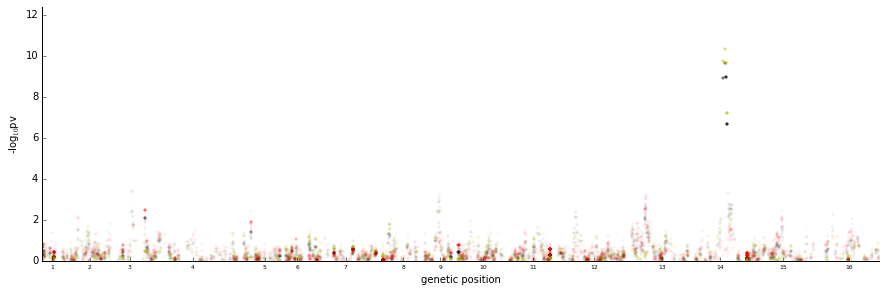

In [33]:
tests = ['Any effect test','Interaction effect test']
lim = -1.2*sp.log10(sp.array([pvalues['alternative_any'].min(),
        pvalues['null_common'].min(),pvalues['specific'].min()]).min())
pl.figure(figsize=[15,10])
plt = pl.subplot(2,1,1)
plot_manhattan(position['pos_cum'],pvalues['alternative_any'],
               chromBounds,colorS='k',colorNS='k',lim=lim,alphaNS=0.05)
plot_manhattan(position['pos_cum'],pvalues['null_common'],
               chromBounds,colorS='y',colorNS='y',lim=lim,alphaNS=0.05)
plot_manhattan(position['pos_cum'],pvalues['specific'],
               chromBounds,colorS='r',colorNS='r',lim=lim,alphaNS=0.05)

### Example: any, common and specific effect tests across environments for all genes in the pathway 

In [34]:
pvalues_dict={}

for gene_idx,gene in enumerate(lysine_group):
    # select all environmens for gene YJR139C in lysine_group
    phenotype_query = "(gene_ID == '%s')" % gene
    print "running GxE GWAS tests on %s" % phenotype_query
    data_subsample = dataset.subsample_phenotypes(phenotype_query=phenotype_query,
                                               intersection=True)

    #get variables we need from data
    phenotypes,sample_idx = data_subsample.getPhenotypes(phenotype_query=phenotype_query,
                                                         intersection=True)
    assert sample_idx.all()
    if phenotypes.shape[1]==0:
        continue
    
    snps = data_subsample.getGenotypes(impute_missing=True)
    
    sample_relatedness = data_subsample.getCovariance()

    #set parameters for the analysis
    N, P = phenotypes.shape          

    covs = None                 #covariates
    Acovs = None                #the design matrix for the covariates   
    Asnps0 = sp.ones((1,P))     #the null model design matrix for the SNPs
    Asnps1 = sp.zeros((2,P))    #the alternative model design matrix for the SNPs
    Asnps1[0,:] = 1.0           
    Asnps1[1,0] = 1.0       
    K1r = sample_relatedness    #the first sample-sample covariance matrix (non-noise)
    K2r = sp.eye(N)             #the second sample-sample covariance matrix (noise)
    K1c = None                  #the first phenotype-phenotype covariance matrix (non-noise)
    K2c = None                  #the second phenotype-phenotype covariance matrix (noise)
    covar_type = 'freeform'     #the type of the trait/trait covariance to be estimated  
    searchDelta = False         #specify if delta should be optimized for each SNP
    test="lrt"                  #specify type of statistical test

    # Running the analysis
    # when cov are not set (None), LIMIX considers an intercept (covs=SP.ones((N,1)))
    pvalues = qtl.test_interaction_lmm_kronecker(snps=snps,phenos=phenotypes.values,
        covs=covs,Acovs=Acovs,Asnps1=Asnps1,Asnps0=Asnps0,K1r=K1r,K2r=K2r,K1c=K1c,
        K2c=K2c,trait_covar_type=covar_type,searchDelta=searchDelta)

    #convert P-values to a DataFrame for nice output writing:
    pvalues = pd.DataFrame(data=sp.concatenate(pvalues).T,index=data_subsample.geno_ID,
                           columns=["specific","null_common","alternative_any"])
    key = "pvalues_%s" % gene
    pvalues_dict[key] = pvalues


running GxE GWAS tests on (gene_ID == 'YIL094C')
.. Training the backgrond covariance with a GP model
Background model trained in 0.05 s
running GxE GWAS tests on (gene_ID == 'YDL182W')
.. Training the backgrond covariance with a GP model
Background model trained in 0.03 s
running GxE GWAS tests on (gene_ID == 'YDL131W')
.. Training the backgrond covariance with a GP model
Background model trained in 0.03 s
running GxE GWAS tests on (gene_ID == 'YER052C')
.. Training the backgrond covariance with a GP model
Background model trained in 0.03 s
running GxE GWAS tests on (gene_ID == 'YBR115C')
.. Training the backgrond covariance with a GP model
Background model trained in 0.04 s
running GxE GWAS tests on (gene_ID == 'YDR158W')
.. Training the backgrond covariance with a GP model
Background model trained in 0.04 s
running GxE GWAS tests on (gene_ID == 'YNR050C')
.. Training the backgrond covariance with a GP model
Background model trained in 0.03 s
running GxE GWAS tests on (gene_ID == 'YJ

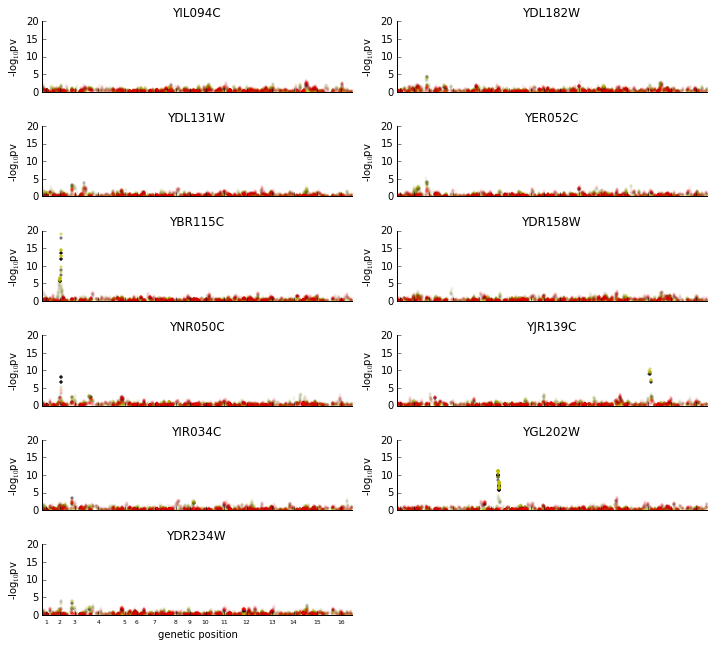

In [35]:
# plotting all manhattan plots
pl.figure(1,figsize=(10,16))
lim = 20
for g in range(G):
    plt = pl.subplot(G,2,g+1)
    pl.title(lysine_group[g])
    if g!=G-1:   xticklabels = False
    else:        xticklabels = True
    pv = pvalues_dict['pvalues_%s'%lysine_group[g]]
    plot_manhattan(position['pos_cum'],pv['alternative_any'],
        chromBounds,colorS='k',colorNS='k',lim=lim,alphaNS=0.05,xticklabels=xticklabels)
    plot_manhattan(position['pos_cum'],pv['null_common'],
        chromBounds,colorS='y',colorNS='y',lim=lim,alphaNS=0.05,xticklabels=xticklabels)
    plot_manhattan(position['pos_cum'],pv['specific'],
        chromBounds,colorS='r',colorNS='r',lim=lim,alphaNS=0.05,xticklabels=xticklabels)
pl.tight_layout()

All any-effect eQTL are explained by environmental persistent signal
with the exception of the peak on chromosome 2 for gene YNR050C that has
an almost significant specific component.
These results together with those obtained from the GxE variance decomposition analysis
suggest that the strong transGxE signal of the genes in the pathway is due to interaction
of the poligenic effect with the environment.


## Multi trait Multi locus models

# Predictions and Model Selection

In this section we discuss how to use the phenotype prediction tool in the LIMIX variance decomposition module to monitor overfitting and perform model selection.
We start by discussing how to impose regularization on the trait covariance matrices and how to make phenotype predicitons. Finally we show how to use cross validation to select the extent of the penalization.

## Regularized maximum likelihood

When considering high number of traits,
flexible models for trait covariance matrices
are characterized by a large number of parameters
and may lead to overfitting.
For example, general semi-definite positive matrices (\textit{freeform} matrices) are
parameterized by $\frac{1}{2}P(P+1)$ real values,
with the number of parameters increasing quadratically in the number of traits
while the data only linearly.

In order to prevent this, LIMIX makes available to the user
less complex covariance models (e.g. block and low rank models) as well as
the possibility to add a regularization term over the trait covariance matrices

\begin{equation}
\min_{\boldsymbol{\theta}}
\underbrace{ -
\log\mathcal{N}\left(\text{vec}\mathbf{Y}\;|\;\sum_i\mathbf{F}_i\mathbf{W}_i\mathbf{A}_i,\;
\mathbf{C}_g(\boldsymbol{\theta})\otimes\mathbf{R}+\mathbf{C}_n(\boldsymbol{\theta})\otimes\mathbf{I}\right)
}_{\text{data fit}}+
\underbrace{
\lambda \sum_{i \neq j}\left({\mathbf{C}_g(\boldsymbol{\theta})_{ij}}^2+{\mathbf{C}_n(\boldsymbol{\theta})_{ij}}^2\right)
}_{\text{regularizer}}
\end{equation}
where $\otimes$ denotes the Kronecker product and $\lambda$ is the extent of the penalization.
Notice that the penalization is only applied to off-diagonal elements
to preserve unbiased marginal heritability estimates.

### Example: setting regularization

In [36]:
#create a complex query on the gene_ID and environment:
# select environment 0 for all genes in lysine_group
phenotype_query = "(gene_ID in %s) & (environment==0)" % str(lysine_group)

data_subsample = dataset.subsample_phenotypes(phenotype_query=phenotype_query,
                                           intersection=True)

#get variables we need from data
phenotypes,sample_idx = data_subsample.getPhenotypes(phenotype_query=phenotype_query,
                                                     intersection=True) 
assert sample_idx.all()

sample_relatedness = data_subsample.getCovariance()

# variance component model
vc = var.VarianceDecomposition(phenotypes.values)
vc.addFixedEffect()
vc.addRandomEffect(K=sample_relatedness,trait_covar_type='lowrank_diag')
vc.addRandomEffect(is_noise=True,trait_covar_type='lowrank_diag')

# setting different extent of panalization
lambds = [1e4, # very highly penalized model
          1e3,1e2,1e1,
          1e0 # lowly penalized model
         ]
Cg = []
Cn = []
for lambd in lambds:
    print "optimizing model with lambda=%.1e" % lambd
    # fit the model with extent of penalization lambd
    vc.optimize(lambd=lambd)
    # store trait covariance matrices
    Cg.append(vc.getTraitCovar(0))
    Cn.append(vc.getTraitCovar(1))

optimizing model with lambda=1.0e+04
optimizing model with lambda=1.0e+03
optimizing model with lambda=1.0e+02
optimizing model with lambda=1.0e+01
optimizing model with lambda=1.0e+00


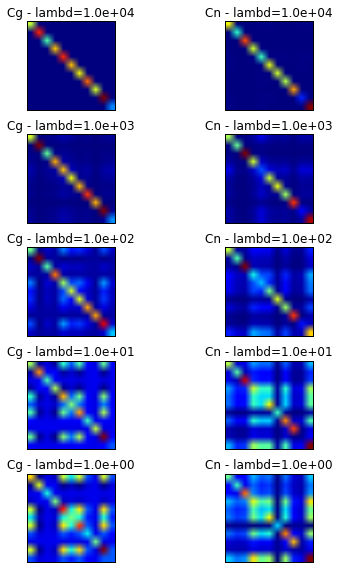

In [37]:
pl.figure(1,figsize=(6,8))
for i in range(len(lambds)):
    plt = pl.subplot(len(lambds),2,2*i+1)
    pl.title('Cg - lambd=%.1e'%lambds[i])
    pl.imshow(Cg[i])
    plt.set_xticks([])
    plt.set_yticks([])
    plt = pl.subplot(len(lambds),2,2*i+2)
    pl.title('Cn - lambd=%.1e'%lambds[i])
    pl.imshow(Cn[i])
    plt.set_xticks([])
    plt.set_yticks([])
pl.tight_layout()

## Phenotype predictions

Let $N$ denote the number of individuals for which we have
both phenotypes $\mathbf{Y}\in\mathcal{R}^{N,P}$ and genotypes $\mathbf{X}\in\mathcal{R}^{N,S}$
and $N^\star$ denote the number of individuals for which we have genotypes
$\mathbf{X}^\star\in\mathcal{R}^{N^\star,S}$ and we want to predict phenotypic values.
Moreover, let us introduce
\begin{eqnarray}
\mathbf{F_i}   &=& \text{fixed effect sample design for the $N$ samples} \in \mathcal{R}^{N,K} \\
\mathbf{F_i^\star}   &=& \text{fixed effect sample design for the $N^\star$ samples} \in \mathcal{R}^{N^{\star},K} \\
\mathbf{R}   &=& \text{sample relatedeness matrix} = \mathbf{X}\mathbf{X}^T \in \mathcal{R}^{N,N} \\
\mathbf{R^\star}   &=& \text{cross relatedeness matrix} = \mathbf{X}{\mathbf{X}^\star}^T \in \mathcal{R}^{N,N^\star}
\end{eqnarray}

The LIMIX variance decomposition model implements
best linear unbiased prediction (BLUP) where $\mathbf{F}_i$, $\mathbf{R}$ and $\mathbf{Y}$ are used to estimate
the model parameters while $\mathbf{F}_i^\star$, $\mathbf{R}^\star$ and $\mathbf{Y}^\star$ are used
for predicticting:
\begin{equation}
\mathbf{Y}^\star=
\sum_{i} \mathbf{F}^\star_i\mathbf{W}_i\mathbf{A}_i +
{\mathbf{R}^\star}^T
\mathbf{Z}
\mathbf{C}
\end{equation}
where
\begin{eqnarray}
\text{vec}\mathbf{Z}
& = &
\mathbf{K}^{-1}
{\text{vec}{\left(
{{\mathbf{Y}}} -
\sum_{i} \mathbf{F}_i\mathbf{W}_i\mathbf{A}_i
\right)}}\\
\mathbf{K}
& = &
\mathbf{C}_g \otimes \mathbf{R}+
\mathbf{C}_n \otimes \mathbf{I}
\end{eqnarray}

While here we show only the case with two random effect, a polygenic random effect and a noise random effect,
the implementation in LIMIX can be used for any number of random effects.

### Example: predictions for gene YJR139C

In this example we predict gene expression from genotype for gene YJR139C. 
We split the samples in two parts:
- training samples (~90% of the samples), whose phenotype and genotype values are used to train the model
- test samples (~10% of the samples), whose genotypes are used for predictions.

Predicted phenotypes for test samples are then compared with the corresponding measured phenotypes.
The code for the multi-trait case is identical.

To use the prediction method in the variance decomposition module, it is sufficient to specify for each fixed and random effect to use for predictions the test sample design $\mathbf{F}^\star$ and the cross covariance $\mathbf{R}^\star$ respectively (in addition to $\mathbf{F}$ and $\mathbf{R}$). Predicting using only part of the fixed and random effect terms is also possible.


In [38]:
#create a complex query on the gene_ID and environment:
# select environment 0 for gene YJR139C
phenotype_query = "(gene_ID=='YJR139C') & (environment==0)"

data_subsample = dataset.subsample_phenotypes(phenotype_query=phenotype_query,
                                           intersection=True)

#get variables we need from data
phenotypes,sample_idx = data_subsample.getPhenotypes(phenotype_query=phenotype_query,
                                                     intersection=True) 
assert sample_idx.all()

sample_relatedness = data_subsample.getCovariance()

# split samples into training and test
sp.random.seed(0)
r   = sp.random.permutation(phenotypes.shape[0])
nfolds = 10
Icv = sp.floor(((sp.ones((phenotypes.shape[0]))*nfolds)*r)/phenotypes.shape[0])
Itrain  = Icv!=0
Itest   = Icv==0
pheno_train = phenotypes.values[Itrain,:]
pheno_test  = phenotypes.values[Itest,:]

# variance component model
vc = var.VarianceDecomposition(pheno_train)
vc.setTestSampleSize(Itest.sum())
#1. add intercept
F     = sp.ones([pheno_train.shape[0],1])
Ftest = sp.ones([pheno_test.shape[0],1])
vc.addFixedEffect(F=F,Ftest=Ftest)
#2. add polygenic random effect
Rtrain = sample_relatedness[Itrain,:][:,Itrain]
Rcross = sample_relatedness[Itrain,:][:,Itest]
vc.addRandomEffect(K=Rtrain,Kcross=Rcross)
#3. noise
vc.addRandomEffect(is_noise=True)
# train the model on the test
vc.optimize()
# predict on the training
predicted_phenos = vc.predictPhenos()

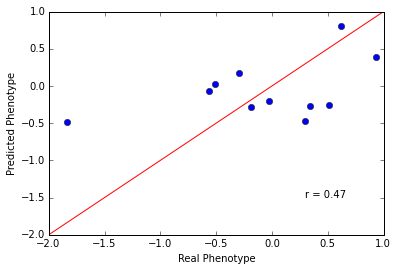

In [39]:
# plot predicted versus real phenotypes
rho = sp.corrcoef(predicted_phenos.T,pheno_test.T)[0,1]
pl.plot(pheno_test.ravel(),predicted_phenos.ravel(),'o')
pl.xlabel('Real Phenotype')
pl.ylabel('Predicted Phenotype')
pl.plot([-2,1],[-2,1],'r')
pl.xlim(-2,1)
pl.ylim(-2,1)
pl.text(0.3,-1.5,'r = %.2f'%(rho))

## Cross-Validation Model and Selection

LIMIX variance decomposition has a method for cross-validation that builds on the prediction methods we have just showcased.
The entire dataset is split into $n$ folds, each fold is predicted independentely after training the model on the remaining $n-1$ so that the whole matrix of predicted phenotypes can be obtained.
This can be used to perform model selection across different genetic models.

In the following we show how the cross-validation method can be used to select the extent of the penalization on the trait covariance matrices.

### Example: selecting the extend of the penalization

In [40]:
#create a complex query on the gene_ID and environment:
# select environment 0 for all genes in lysine_group
phenotype_query = "(gene_ID in %s) & (environment==0)" % str(lysine_group)

data_subsample = dataset.subsample_phenotypes(phenotype_query=phenotype_query,
                                           intersection=True)

#get variables we need from data
phenotypes,sample_idx = data_subsample.getPhenotypes(phenotype_query=phenotype_query,
                                                     intersection=True) 
assert sample_idx.all()
N,P=phenotypes.shape

sample_relatedness = data_subsample.getCovariance()

# variance component model
vc = var.VarianceDecomposition(phenotypes.values)
vc.addFixedEffect()
vc.addRandomEffect(K=sample_relatedness,trait_covar_type='lowrank_diag',rank=2)
vc.addRandomEffect(is_noise=True,trait_covar_type='lowrank_diag',rank=2)

# values of lambda to be considered
lambds = 10**sp.linspace(4,0,10)

# options for cross validation
seed = 0
n_folds = 10

# cross validation for different values of lambda
MSE = []
for lambd in lambds:
    print "Optimizing model with lambda:", lambd
    predicted_phenos = vc.crossValidation(seed=seed,n_folds=n_folds,
                                          lambd=lambd,verbose=False)
    mse = ((predicted_phenos-phenotypes.values)**2).sum()/float(N*P)
    MSE.append(mse)

Optimizing model with lambda: 10000.0


ValueError: operands could not be broadcast together with shapes (2,) (109,11) 

In [ ]:
plt = pl.subplot(1,1,1)
pl.plot(sp.log10(lambds),MSE,'--',color='k')
pl.plot(sp.log10(lambds),MSE,'o',color='white')
plt.invert_xaxis()
pl.xlabel('$log_{10}\lambda$')
pl.ylabel('Mean Squared Error')

# Accounting for gene expression heterogeneity

LIMIX provides implementation for preivously proposed mixed models to estimate gene expression heterogeneity due to unobserved confounders (e.g. <cite data-cite="kang2008accurate">Kang et al., 2008</cite> & <cite data-cite="fusi2012joint">Fusi et al., 2012</cite>). 

LIMIX estimates a sample-by-sample covariance matrix that accounts for both genetic and non-genetic confounders. This approach is applicable in studies with high-dimensional molecular phenotypes such as gene expression levels. 
In the following we briefly introduce a generic model for expresison heterogeneity that is closely related to the PANAMA approach <cite data-cite="fusi2012joint">(Fusi et al., 2012)</cite> and show how this can be used for eQTL analyses.

## The Genetic Model

Sarting form a generative model that includes both hidden and known covaraites, we start with the a generative model of the form
\begin{equation}
\mathbf{y}_p =
\mathbf{u} + \boldsymbol{\eta} + \boldsymbol{\psi},\;\;\;\;\forall p
\end{equation}
\begin{equation}
\mathbf{u}\sim\mathcal{N}\left(\mathbf{0},\;\sigma_g^2\mathbf{R}_g\right),\;
\boldsymbol{\eta}\sim\mathcal{N}\left(\mathbf{0},\;\mathbf{R}_c \left(\boldsymbol{\alpha}\right)\right),\;
\boldsymbol{\psi}\sim\mathcal{N}\left(\mathbf{0},\;\sigma_e^2\mathbf{I}\right)
\nonumber
\end{equation}
where we assume independence of the traits conditioned on the latent factors and we have introduced
\begin{eqnarray}
\mathbf{R}_g &=& \text{sample genetic relatedeness matrix} = \mathbf{XX}^T \in \mathcal{R}^{N,N} \\
\mathbf{R}_c &=& \text{inferred sample relatedeness matrix due to unobserved covariates} \in \mathcal{R}^{N,N}
\end{eqnarray}
The parameters of the model are $\left\{\boldsymbol{\alpha},\sigma_g^2,\sigma_e^2\right\}$.
As full rank matrices might overfit the data explaining away genetic signal,
LIMIX models $\mathbf{R}_c\left(\boldsymbol{\alpha}\right)$ as rank $r$ matrix and allows the user to choose $r$.
A sensible value for $r$ can be chosen by looking at
the number of PCAs of the sample-by-sample empirical covariance matrix explaining 70\%-90\% of the variance; see also discussion in <cite data-cite="fusi2012"> Fusi et al. 2012</cite>

Once $\mathbf{R}_c$ is learned, the new sample relatedeness matrix $\sigma_g^2\mathbf{R}_g+\mathbf{R}_c$
can be plugged in the GWAS and variance decomposition tools in LIMIX both for single and multivariate analysis.
In the following we will refer to $\mathbf{R}_c$ (after normalizing) as *hterogeneity matrix* while
we will refer to the new sample relatedeness matrix $\sigma_g^2\mathbf{R}_g+\mathbf{R}_c$ (after normalizing) as *total sample covariance matrix*.

## Example: Accounting for gene expression heterogeneity in the yeast dataset

In [41]:
# import panama
import limix.modules.panama as panama

# import data
phenotypes,sample_idx = data_subsample.getPhenotypes(intersection=True)
assert sample_idx.all()
sample_relatedness = data_subsample.getCovariance()

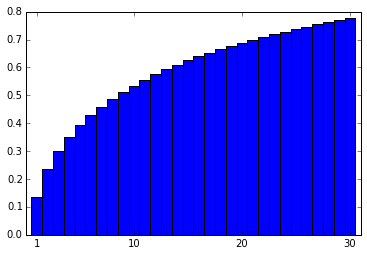

In [42]:
# determine the number of ranks to consider in the PANAMA matrix
# by looking at the variance explained by PCs
cum_var = panama.PC_varExplained(phenotypes.values)
plt = pl.subplot(1,1,1)
pl.bar(sp.arange(30)+0.5,cum_var[:30],width=1)
pl.xlim(0,31)
ticks = sp.linspace(0,30,4); ticks[0] = 1
plt.set_xticks(ticks)

In [43]:
# train panama with rank=15 (~60% of the variance)
p = panama.PANAMA(Y=phenotypes.values,Kpop=sample_relatedness)
p.train(rank=15)
# retrieve stuff
Kpanama = p.get_Kpanama()
Ktot    = p.get_Ktot()
vComp   = p.get_varianceComps()

TypeError: unsupported operand type(s) for +: 'int' and 'str'

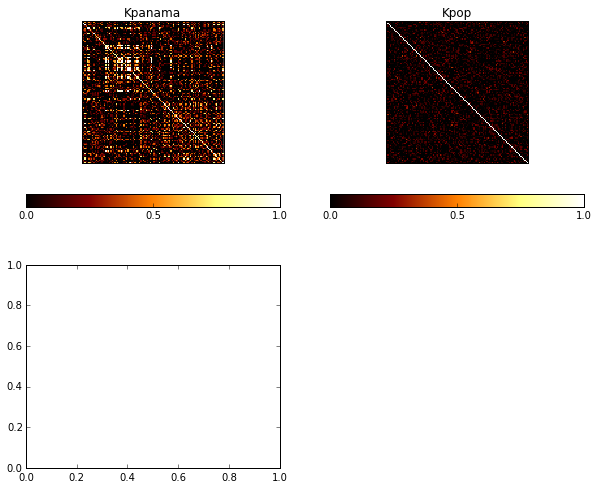

In [44]:
# compare Kpanama matrix, Kpop, and the total matrix
pl.figure(1,figsize=(10,8))
plt = pl.subplot(2,2,1)
pl.title('Kpanama')
pl.imshow(Kpanama,vmin=0,vmax=1,interpolation='none',cmap=cm.afmhot)
pl.colorbar(ticks=[0,0.5,1],orientation='horizontal')
plt.set_xticks([])
plt.set_yticks([])
plt = pl.subplot(2,2,2)
pl.title('Kpop')
pl.imshow(sample_relatedness,vmin=0,vmax=1,interpolation='none',
          cmap=cm.afmhot)
pl.colorbar(ticks=[0,0.5,1],orientation='horizontal')
plt.set_xticks([])
plt.set_yticks([])
plt = pl.subplot(2,2,3)
pl.bar(sp.arange(3)+0.2,vComp,width=0.6)
plt.set_xticks([0.5,1.5,2.5])
plt.set_xticklabels(['Kpanama','Kpop','noise'])
pl.ylabel('Variance Explained')
plt = pl.subplot(2,2,4)
pl.title('Ktot')
pl.imshow(Ktot,vmin=0,vmax=1,interpolation='none',cmap=cm.afmhot)
pl.colorbar(ticks=[0,0.5,1],orientation='horizontal')
plt.set_xticks([])
plt.set_yticks([])